Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving!! generated-art-0000.png


  0%|          | 0/988 [00:00<?, ?it/s]

ValueError: expected 4D input (got 3D input)

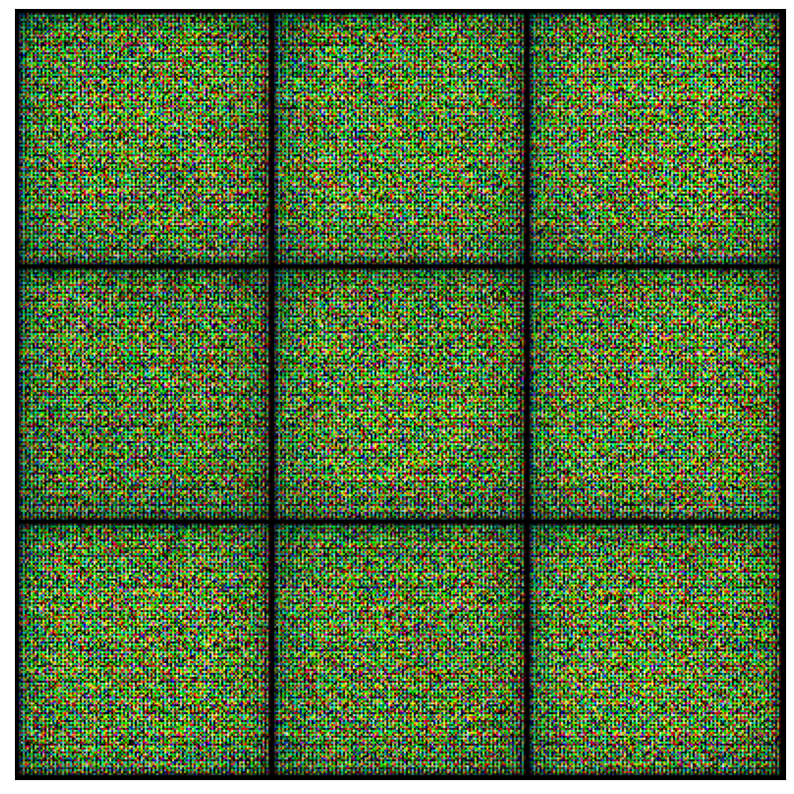

In [1]:
## Import Libraries ans Packages
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Define useful parameters
batch_size = 128
image_size = (128,128)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

### Import and Load the Dataset
transform_dataset = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(*stats)])
train_dataset = torchvision.datasets.ImageFolder(root='/Users/Sachith/dataset/Arts', transform=transform_dataset)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

### Denormalize Image to originals
def denorm(image_tensors):
    return image_tensors * stats[1][0] + stats[0][0]

### Show Images
def show_arts(arts, max=9):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(arts.detach()[:max]), nrow=3).permute(1, 2, 0))

def show_sample(data_load, max=9):
    for arts, _ in data_load:
        show_arts(arts, max)
        break

### Functions for get the default device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
train_dataloader = DeviceDataLoader(train_dataloader, device)

## Build up the Discriminator
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True), 

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),  

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),  

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),  
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

## Set to device
discriminator = to_device(discriminator, device)

## Set the random noise size 
noise_size = 150

## Build up the Generator
generator = nn.Sequential(
    nn.ConvTranspose2d(noise_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

generator = to_device(generator, device)

def discriminator_train(real_arts, optimizer_discriminator):
    optimizer_discriminator.zero_grad() ## Clear the gradients
    
    ## Input real Arts
    real_predictions = discriminator(real_arts)
    real_labels = torch.ones(real_arts.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_predictions, real_labels)
    real_score = torch.mean(real_predictions).item()

    ## Generate fake Arts
    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
    fake_arts = generator(noise)

    ## Input fake Arts to Discriminator
    fake_labels = torch.zeros(fake_arts.size(0), 1, device=device)
    fake_predictions = discriminator(fake_arts)
    fake_loss = F.binary_cross_entropy(fake_predictions, fake_labels)
    fake_score = torch.mean(fake_predictions).iteme()

    ## Discriminator Update
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_discriminator.step()

    return loss.item(), real_score, fake_score

def generator_train(optimizer_generator):
    optimizer_generator.zero_grad() ## Clear gradients

    ## Generate fake Arts
    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
    fake_arts = generator(noise)

    ## Trick the Discriminator
    predictions = discriminator(fake_arts)
    labels = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(predictions, labels)

    return loss.item()

## Define a function to save generated Arts
from torchvision.utils import save_image
import os

dir = '/Users/Sachith/dataset/Generated Arts'
os.makedirs(dir, exist_ok=True)

def save_arts(index, noise_tensors, show=True):
    fake_arts = generator(noise_tensors)
    fake_artName = 'generated-art-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_arts), os.path.join(dir, fake_artName), nrow=3)
    print('Saving!!', fake_artName)
    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_arts.cpu().detach(), nrow=3).permute(1, 2, 0))

### Set a fixed noise
fixed_noise = torch.randn(9, noise_size, 1, 1, device=device)
save_arts(0, fixed_noise)

from tqdm.notebook import tqdm
def fit(epochs, learning_rate, start_index=1):
    torch.cuda.empty_cache()

    ## Loss and Score
    losses_discriminator = []
    losses_generator = []
    real_scores = []
    fake_scores = []

    ## Optimizers
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_arts, _ in tqdm(train_dataset):
            ## Train the Discriminator
            loss_discriminator, real_score, fake_score = discriminator_train(real_arts, optimizer_discriminator)
            ## Train the Generator
            loss_generator = generator_train(optimizer_generator)

        ## Records!
        losses_generator.append(loss_generator)
        losses_discriminator.append(loss_discriminator)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], Generator Loss: {:.4f}, Discriminator Loss: {:.4f}, Real Score: {:.4f}, Fake Score: {:.4f}".format(
            epoch+1, epochs, loss_generator, loss_discriminator, real_score, fake_score
            ))

        # Save generated images
        save_arts(epoch + start_index, fixed_noise, show=False)
    
    return losses_generator, loss_discriminator, real_scores, fake_scores

learning_rate = 0.001
epochs = 250

History = fit(epochs, learning_rate)

print("END!")
